In [65]:
#import potrzebnych bibliotek
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

In [35]:
#funkcja obliczająca odległość między dwoma wierzchołkami z matematycznym zaokrągleniem
def distance(x1,x2,y1,y2):
    return np.floor(np.sqrt((x1-x2)**2+(y1-y2)**2)+0.5)

In [36]:
#wczytanie pierwszej instancji (kroA100)

instance = pd.read_csv('kroA100.tsp', sep=' ', names=['node', 'x', 'y'], skiprows=6, skipfooter=1,
                      engine='python')
kroA100 = []

for index1, row1 in instance.iterrows():
    tmp = []
    for index2, row2 in instance.iterrows():
        if (index1==index2):
            tmp.append(0)
        else:
            tmp.append(distance(row1['x'],row2['x'],row1['y'],row2['y']))
    kroA100.append(tmp)

np.array(kroA100)

array([[   0., 1693., 2252., ...,  783., 1468., 2643.],
       [1693.,    0., 1708., ..., 1911., 3156., 1831.],
       [2252., 1708.,    0., ..., 1786., 3315.,  454.],
       ...,
       [ 783., 1911., 1786., ...,    0., 1535., 2228.],
       [1468., 3156., 3315., ..., 1535.,    0., 3760.],
       [2643., 1831.,  454., ..., 2228., 3760.,    0.]])

In [37]:
#wczytanie drugiej instancji (kroB100)

instance2 = pd.read_csv('kroB100.tsp', sep=' ', names=['node', 'x', 'y'], skiprows=6, skipfooter=1,
                      engine='python')

kroB100 = []

for index1, row1 in instance2.iterrows():
    tmp = []
    for index2, row2 in instance2.iterrows():
        if (index1==index2):
            tmp.append(0)
        else:
            tmp.append(distance(row1['x'],row2['x'],row1['y'],row2['y']))
    kroB100.append(tmp)

np.array(kroB100)

array([[   0., 2607.,  549., ...,  229.,  618., 1249.],
       [2607.,    0., 3154., ..., 2621., 3075., 2661.],
       [ 549., 3154.,    0., ...,  571.,  403., 1499.],
       ...,
       [ 229., 2621.,  571., ...,    0.,  480., 1475.],
       [ 618., 3075.,  403., ...,  480.,    0., 1796.],
       [1249., 2661., 1499., ..., 1475., 1796.,    0.]])

In [38]:
#funkcja obliczająca całkowitą długość cyklu
def distance_sum(cycle,matrix):
    distance = 0
    for i in range(len(cycle)):
        if i==len(cycle)-1:
            distance+=matrix[cycle[i]][cycle[0]]
        else:
            distance+=matrix[cycle[i]][cycle[i+1]]
    return distance

In [39]:
#algorytm zachłanny inspirowany metodą najbliższego sąsiada
def nearest_neighbour(matrix, cycle, remaining):
    min_distance = matrix[cycle[0]][remaining[0]]
    min_node = remaining[0]
    node_cycle = cycle[0]
    for node_to_add in remaining:
        for node_in_cycle in cycle:
            if matrix[node_to_add][node_in_cycle] < min_distance:
                min_distance = matrix[node_to_add][node_in_cycle]
                min_node = node_to_add
                node_cycle = node_in_cycle
    return min_node, node_cycle

In [40]:
#algorytm zachłanny inspirowany metodą rozbudowy cyklu
def greedy_cycle(matrix, cycle, remaining):
    min_distance = 999999999
    index = -1
    min_node = cycle[0]
    for node_to_add in remaining:
        for i in range (len(cycle)):
            if i!=len(cycle)-1:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[i+1]][node_to_add] - matrix[cycle[i]][cycle[i+1]]
            else:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[0]][node_to_add] - matrix[cycle[i]][cycle[0]]
            if tmp_distance < min_distance:
                min_distance = tmp_distance
                min_node = node_to_add
                index = i
    return min_node, index

In [41]:
#funkcja zwracająca listę wierzchołków, dla których najlepsze miejsce wstawienia to miejsce w cyklu o podanym indeksie
def nodes_with_best_given_index(matrix,cycle,remaining,given_index):
    result_nodes = []
    for node_to_add in remaining:
        best1 = 9999999999998
        best2 = 9999999999999
        index = -1
        for i in range (len(cycle)):
            if i!=len(cycle)-1:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[i+1]][node_to_add] - matrix[cycle[i]][cycle[i+1]]
            else:
                tmp_distance = matrix[cycle[i]][node_to_add]+ matrix[cycle[0]][node_to_add] - matrix[cycle[i]][cycle[0]]
            if tmp_distance < best2:
                if tmp_distance < best1:
                    best2 = best1
                    best1 = tmp_distance
                    index = i
                else:
                    best2 = tmp_distance
        if index == given_index:
            result_nodes.append([node_to_add,best1,best2])
    return result_nodes

In [42]:
def calculate_regret_with_weight(list_nodes):
    list_nodes = np.array(list_nodes)
    difference = list_nodes[:,2]-1.2*(list_nodes[:,1])
    best_result_index = np.argmax(difference)
    return int(list_nodes[best_result_index][0])

In [43]:
def greedy_regret_with_weight(matrix, cycle, remaining):
    best_node_to_add, best_index = greedy_cycle(matrix, cycle, remaining)
    nodes_on_the_same_position = nodes_with_best_given_index(matrix, cycle, remaining, best_index)
    return calculate_regret_with_weight(nodes_on_the_same_position), best_index

In [44]:
#losowanie pierwszego wierzchołka startowego - drugi wyznaczany jest jako najdalszy od pierwszego
def get_start_nodes(matrix):
    first_start=rd.randint(0, 99)
    second_start=np.argmax(matrix[first_start])
    return first_start,second_start

In [45]:
#utworzenie dwóch list (cyklów) i dodanie wierzchołków startowych oraz utworzenie listy z pozostałymi wierzchołkami
def create_cycles(first_start, second_start):
    cycle1=[]
    cycle2=[]
    remaining = list(range(100))
    remaining.remove(first_start)
    remaining.remove(second_start)
    cycle1.append(first_start)
    cycle2.append(second_start)
    return cycle1, cycle2, remaining

In [46]:
def calculate_greedy_regret_with_weight(matrix, cycle1, cycle2, remaining):
    node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle1, remaining)
    index = cycle1.index(node_in_cycle)
    cycle1.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, node_in_cycle = nearest_neighbour(matrix, cycle2, remaining)
    index = cycle2.index(node_in_cycle)
    cycle2.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, index = greedy_cycle(matrix, cycle1, remaining)
    cycle1.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    node_to_add, index = greedy_cycle(matrix, cycle2, remaining)
    cycle2.insert(index+1, node_to_add)
    remaining.remove(node_to_add)

    while (remaining):
        node_to_add, index = greedy_regret_with_weight(matrix, cycle1, remaining)
        index = int(index)
        cycle1.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
        if not remaining:
             break
        node_to_add, index = greedy_regret_with_weight(matrix, cycle2, remaining)
        index = int(index)
        cycle2.insert(index+1, node_to_add)
        remaining.remove(node_to_add)
    return([distance_sum(cycle1,matrix)+distance_sum(cycle2,matrix), cycle1, cycle2])

In [47]:
results_kroA100 = []
results_kroB100 = []
iterate = 0
while (iterate<100):
    #obliczanie dla kroA100
    first_start, second_start = get_start_nodes(kroA100)   
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroA100.append(calculate_greedy_regret_with_weight(kroA100, cycle1, cycle2, remaining))
    
    #obliczanie dla kroB100
    first_start, second_start = get_start_nodes(kroB100)
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    results_kroB100.append(calculate_greedy_regret_with_weight(kroB100, cycle1, cycle2, remaining))
    iterate+=1

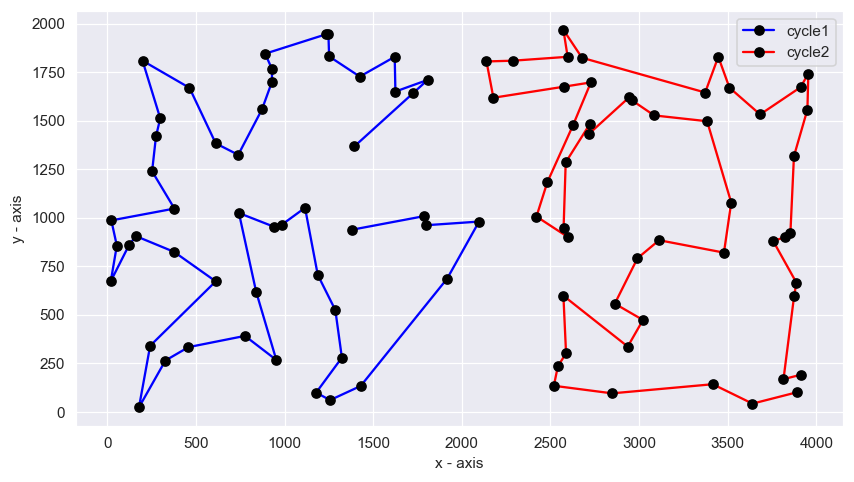

In [48]:
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')
    
best_result = np.argmin(results_kroA100, axis=0)
cycle1 = results_kroA100[best_result[0]][1]
cycle2 = results_kroA100[best_result[0]][2]

#cycle1.append(cycle1[0])
#cycle2.append(cycle2[0])

coordinate_x_cycle1 = []
coordinate_y_cycle1 = []
coordinate_x_cycle2 = []
coordinate_y_cycle2 = []
for node in cycle1:
    coordinate_x_cycle1.append(instance.loc[node]['x'])
    coordinate_y_cycle1.append(instance.loc[node]['y'])
for node in cycle2:
    coordinate_x_cycle2.append(instance.loc[node]['x'])
    coordinate_y_cycle2.append(instance.loc[node]['y'])
    
# plotting the line 1 points
plt.plot(coordinate_x_cycle1, coordinate_y_cycle1, '-bo',  c='blue', mfc='k', mec='k', label="cycle1")
plt.plot(coordinate_x_cycle2, coordinate_y_cycle2, '-bo',  c='red', mfc='k', mec='k', label="cycle2")
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [49]:
def difference_in_new_cycles(matrix,cycle1,cycle2,node1,node2):
    cycle1_copy=cycle1.copy()
    cycle2_copy=cycle2.copy()
    ind1=cycle1_copy.index(node1)
    ind2=cycle2_copy.index(node2)
    old_distance = distance_sum(cycle1_copy,matrix)+distance_sum(cycle2_copy,matrix)
    cycle1_copy[ind1]=node2
    cycle2_copy[ind2]=node1
    new_distance = distance_sum(cycle1_copy,matrix)+distance_sum(cycle2_copy,matrix)
    return new_distance-old_distance
    

In [50]:
def difference_in_cycle(matrix,cycle1,node1,node2):
    cycle1_copy=cycle1.copy()
    ind1=cycle1_copy.index(node1)
    ind2=cycle1_copy.index(node2)
    old_distance = distance_sum(cycle1_copy,matrix)
    cycle1_copy[ind1]=node2
    cycle1_copy[ind2]=node1
    new_distance = distance_sum(cycle1_copy,matrix)
    return new_distance-old_distance

In [51]:
def difference_in_edges(matrix,cycle,ind1,ind2):
    cycle_copy=cycle.copy()
    old_distance = distance_sum(cycle_copy,matrix)
    result = cycle_copy[:ind1]+list(reversed(cycle_copy[ind1:ind2+1]))+cycle_copy[ind2+1:]
    new_distance = distance_sum(result,matrix)
    return new_distance-old_distance

In [52]:
def greedy_change_nodes(cycle1, cycle2, matrix):
    shuffled_cycle1=cycle1.copy()
    shuffled_cycle2=cycle2.copy()
    rd.shuffle(shuffled_cycle1)
    rd.shuffle(shuffled_cycle2)
    for node1 in shuffled_cycle1:
        for node2 in shuffled_cycle2:
            difference = difference_in_new_cycles(matrix,cycle1,cycle2,node1,node2)
            if difference < 0:
                cycle1_copy=cycle1.copy()
                cycle2_copy=cycle2.copy()
                ind1=cycle1_copy.index(node1)
                ind2=cycle2_copy.index(node2)
                cycle1_copy[ind1]=node2
                cycle2_copy[ind2]=node1
                return cycle1_copy, cycle2_copy
    return None, None

In [53]:
def greedy_change_nodes_in_cycle(cycle,matrix):
    shuffled_cycle1=cycle.copy()
    rd.shuffle(shuffled_cycle1)
    for i in range(len(shuffled_cycle1)-1):
        for j in range(i+1,len(shuffled_cycle1)):
            difference = difference_in_cycle(matrix,cycle,shuffled_cycle1[i],shuffled_cycle1[j])
            if difference < 0:
                cycle1_copy=cycle.copy()
                ind1=cycle1_copy.index(shuffled_cycle1[i])
                ind2=cycle1_copy.index(shuffled_cycle1[j])
                tmp=cycle1_copy[ind1]
                cycle1_copy[ind1]=cycle1_copy[ind2]
                cycle1_copy[ind2]=tmp
                return cycle1_copy
    return None

In [54]:
def greedy_change_edges(cycle, matrix):
    possible_pairs = []
    for i in range(len(cycle)-2):
        for j in range(i+2,len(cycle)):
            possible_pairs.append([i,j])
    shuffled_pairs=possible_pairs.copy()
    rd.shuffle(shuffled_pairs)
    for pair in shuffled_pairs:
        difference = difference_in_edges(matrix,cycle,pair[0],pair[1])
        if difference < 0:
            cycle_copy=cycle.copy()
            result = cycle_copy[:pair[0]]+list(reversed(cycle_copy[pair[0]:pair[1]+1]))+cycle_copy[pair[1]+1:]
            return result
    return None

In [80]:
def steepest_change_nodes(cycle1, cycle2, matrix):
    best_difference = None
    best_node1 = None
    best_node2 = None
    shuffled_cycle1=cycle1.copy()
    shuffled_cycle2=cycle2.copy()
    rd.shuffle(shuffled_cycle1)
    rd.shuffle(shuffled_cycle2)
    for node1 in shuffled_cycle1:
        for node2 in shuffled_cycle2:
            difference = difference_in_new_cycles(matrix,cycle1,cycle2,node1,node2)
            if best_difference is None or difference < best_difference:
                best_difference = difference
                best_node1 = node1
                best_node2 = node2
    if best_difference>=0:
        return None, None
    cycle1_copy=cycle1.copy()
    cycle2_copy=cycle2.copy()
    ind1=cycle1_copy.index(best_node1)
    ind2=cycle2_copy.index(best_node2)
    cycle1_copy[ind1]=best_node2
    cycle2_copy[ind2]=best_node1
    return cycle1_copy, cycle2_copy

In [56]:
def steepest_change_nodes_in_cycle(cycle,matrix):
    best_difference = None
    best_node1 = None
    best_node2 = None
    shuffled_cycle1=cycle.copy()
    rd.shuffle(shuffled_cycle1)
    for i in range(len(shuffled_cycle1)-1):
        for j in range(i+1,len(shuffled_cycle1)):
            difference = difference_in_cycle(matrix,cycle,shuffled_cycle1[i],shuffled_cycle1[j])
            if best_difference is None or difference < best_difference:
                best_difference = difference
                best_node1 = shuffled_cycle1[i]
                best_node2 = shuffled_cycle1[j]
    if best_difference>=0:
        return None
    cycle1_copy=cycle.copy()
    ind1=cycle1_copy.index(best_node1)
    ind2=cycle1_copy.index(best_node2)
    tmp=cycle1_copy[ind1]
    cycle1_copy[ind1]=cycle1_copy[ind2]
    cycle1_copy[ind2]=tmp
    return cycle1_copy

In [57]:
def steepest_change_edges(cycle, matrix):
    best_difference = None
    best_node1 = None
    best_node2 = None
    possible_pairs = []
    for i in range(len(cycle)-2):
        for j in range(i+2,len(cycle)):
            possible_pairs.append([i,j])
    shuffled_pairs=possible_pairs.copy()
    rd.shuffle(shuffled_pairs)
    for pair in shuffled_pairs:
        difference = difference_in_edges(matrix,cycle,pair[0],pair[1])
        if best_difference is None or difference < best_difference:
            best_difference = difference
            best_node1 = pair[0]
            best_node2 = pair[1]
    if best_difference>=0:
        return None
    cycle_copy=cycle.copy()
    result = cycle_copy[:best_node1]+list(reversed(cycle_copy[best_node1:best_node2+1]))+cycle_copy[best_node2+1:]
    return result

In [128]:
def random_walking(matrix, cycle1,cycle2, time_limit):
    result_cycle1 = cycle1.copy()
    result_cycle2 = cycle2.copy()
    best_cycle1 = result_cycle1.copy()
    best_cycle2 = result_cycle2.copy()
    best_distance = distance_sum(cycle1, matrix)+distance_sum(cycle2, matrix)
    start_time = time.time()
    changes = [0, 1, 2, 3, 4]
    indexes = rd.sample(range(50), 2)
    ind1 = indexes[0]
    ind2 = indexes[1]
    while (time.time() - start_time < time_limit):
        change = rd.choice(changes)
        if change == 0:
            ind1 = rd.randint(0,49)
            ind2 = rd.randint(0,49)
            tmp = result_cycle1[ind1]
            result_cycle1[ind1]=result_cycle2[ind2]
            result_cycle2[ind2]=tmp
        elif change == 1:
            tmp=result_cycle1[ind1]
            result_cycle1[ind1]=result_cycle1[ind2]
            result_cycle1[ind2]=tmp
        elif change ==2:
            tmp=result_cycle2[ind1]
            result_cycle2[ind1]=result_cycle2[ind2]
            result_cycle2[ind2]=tmp
        elif change == 3:
            while (np.abs(ind1-ind2)<2):
                indexes = rd.sample(range(50), 2)
                ind1 = indexes[0]
                ind2 = indexes[1]
            min_node=min(ind1, ind2)
            max_node=max(ind1, ind2)
            result_cycle1 = result_cycle1[:min_node]+list(reversed(result_cycle1[min_node:max_node+1]))+result_cycle1[max_node+1:]
        else:
            while (np.abs(ind1-ind2)<2):
                indexes = rd.sample(range(50), 2)
                ind1 = indexes[0]
                ind2 = indexes[1]
            min_node=min(ind1, ind2)
            max_node=max(ind1, ind2)
            result_cycle2 = result_cycle2[:min_node]+list(reversed(result_cycle2[min_node:max_node+1]))+result_cycle2[max_node+1:]
        distance = distance_sum(result_cycle1, matrix)+distance_sum(result_cycle2, matrix)
        if distance < best_distance:
            best_distance = distance
            best_cycle1 = result_cycle1
            best_cycle2 = result_cycle2
    return [best_distance, best_cycle1, best_cycle2]

In [59]:
def measure_greedy_nodes(matrix,cycle1,cycle2):
    changes = [0, 1, 2]
    result_cycle1 = cycle1.copy()
    result_cycle2 = cycle2.copy()
    while changes:
        change = rd.choice(changes)
        if change == 0:
            candidate1, candidate2 = greedy_change_nodes(result_cycle1,result_cycle2,matrix)
            if candidate1 is not None:
                result_cycle1 = candidate1
                result_cycle2 = candidate2
                changes = [0, 1, 2]
            else:
                changes.remove(0)
        elif change == 1:
            candidate1 = greedy_change_nodes_in_cycle(result_cycle1, matrix)
            if candidate1 is not None:
                result_cycle1 = candidate1
                changes = [0, 1, 2]
            else:
                changes.remove(1)
        else:
            candidate2 = greedy_change_nodes_in_cycle(result_cycle2, matrix)
            if candidate2 is not None:
                result_cycle2 = candidate2
                changes = [0, 1, 2]
            else:
                changes.remove(2)
    total_distance = distance_sum(result_cycle1, matrix)+distance_sum(result_cycle2, matrix)
    return [total_distance, result_cycle1, result_cycle2]

In [60]:
def measure_greedy_edges(matrix,cycle1,cycle2):
    changes = [0, 1, 2]
    result_cycle1 = cycle1.copy()
    result_cycle2 = cycle2.copy()
    while changes:
        change = rd.choice(changes)
        if change == 0:
            candidate1, candidate2 = greedy_change_nodes(result_cycle1,result_cycle2,matrix)
            if candidate1 is not None:
                result_cycle1 = candidate1
                result_cycle2 = candidate2
                changes = [0, 1, 2]
            else:
                changes.remove(0)
        elif change == 1:
            candidate1 = greedy_change_edges(result_cycle1, matrix)
            if candidate1 is not None:
                result_cycle1 = candidate1
                changes = [0, 1, 2]
            else:
                changes.remove(1)
        else:
            candidate2 = greedy_change_edges(result_cycle2, matrix)
            if candidate2 is not None:
                result_cycle2 = candidate2
                changes = [0, 1, 2]
            else:
                changes.remove(2)
    total_distance = distance_sum(result_cycle1, matrix)+distance_sum(result_cycle2, matrix)
    return [total_distance, result_cycle1, result_cycle2]

In [82]:
def measure_steepest_nodes(matrix,cycle1,cycle2):
    changes = [0, 1, 2]
    result_cycle1 = cycle1.copy()
    result_cycle2 = cycle2.copy()
    while True:
        changes = [0, 1, 2]
        result_cycle1_c1 = None
        result_cycle2_c1 = None
        result_cycle1_c2 = None
        result_cycle2_c3 = None
        c1 = None
        c2 = None
        c3 = None
        for i in reversed(range(len(changes))):
            if changes[i] == 0:
                candidate1, candidate2 = steepest_change_nodes(result_cycle1,result_cycle2,matrix)
                if candidate1 is not None:
                    result_cycle1_c1 = candidate1.copy()
                    result_cycle2_c1 = candidate2.copy()
                    c1 = (distance_sum(result_cycle1_c1, matrix)+distance_sum(result_cycle2_c1, matrix))-(distance_sum(result_cycle1, matrix)+distance_sum(result_cycle2, matrix))
            elif changes[i] == 1:
                candidate1 = steepest_change_nodes_in_cycle(result_cycle1, matrix)
                if candidate1 is not None:
                    result_cycle1_c2 = candidate1.copy()
                    c2 = distance_sum(result_cycle1_c2, matrix) - distance_sum(result_cycle1, matrix)
            else:
                candidate2 = steepest_change_nodes_in_cycle(result_cycle2, matrix)
                if candidate2 is not None:
                    result_cycle2_c3 = candidate2.copy()
                    c3 = distance_sum(result_cycle2_c3, matrix) - distance_sum(result_cycle2, matrix)
        c_list = [c1, c2, c3]
        if all(c is None for c in c_list):
            break
        best = min(c for c in c_list if c is not None)
        if best == c1:
            result_cycle1=result_cycle1_c1
            result_cycle2=result_cycle2_c1
        elif best == c2:
            result_cycle1 = result_cycle1_c2
        else:
            result_cycle2 = result_cycle2_c3
    total_distance = distance_sum(result_cycle1, matrix)+distance_sum(result_cycle2, matrix)
    return [total_distance, result_cycle1, result_cycle2]

In [62]:
def measure_steepest_edges(matrix,cycle1,cycle2):
    changes = [0, 1, 2]
    result_cycle1 = cycle1.copy()
    result_cycle2 = cycle2.copy()
    while True:
        changes = [0, 1, 2]
        result_cycle1_c1 = None
        result_cycle2_c1 = None
        result_cycle1_c2 = None
        result_cycle2_c3 = None
        c1 = None
        c2 = None
        c3 = None
        for i in reversed(range(len(changes))):
            if changes[i] == 0:
                candidate1, candidate2 = steepest_change_nodes(result_cycle1,result_cycle2,matrix)
                if candidate1 is not None:
                    result_cycle1_c1 = candidate1.copy()
                    result_cycle2_c1 = candidate2.copy()
                    c1 = (distance_sum(result_cycle1_c1, matrix)+distance_sum(result_cycle2_c1, matrix))-(distance_sum(cycle1, matrix)+distance_sum(cycle2, matrix))
            elif changes[i] == 1:
                candidate1 = steepest_change_edges(result_cycle1, matrix)
                if candidate1 is not None:
                    result_cycle1_c2 = candidate1.copy()
                    c2 = distance_sum(result_cycle1_c2, matrix) - distance_sum(cycle1, matrix)
            else:
                candidate2 = steepest_change_edges(result_cycle2, matrix)
                if candidate2 is not None:
                    result_cycle2_c3 = candidate2.copy()
                    c3 = distance_sum(result_cycle2_c3, matrix) - distance_sum(cycle2, matrix)
        c_list = [c1, c2, c3]
        if all(c is None for c in c_list):
            break
        best = min(c for c in c_list if c is not None)
        if best == c1:
            result_cycle1=result_cycle1_c1
            result_cycle2=result_cycle2_c1
        elif best == c2:
            result_cycle1 = result_cycle1_c2
        else:
            result_cycle2 = result_cycle2_c3
    total_distance = distance_sum(result_cycle1, matrix)+distance_sum(result_cycle2, matrix)
    return [total_distance, result_cycle1, result_cycle2]

In [131]:
results_kroA100_random = [[],[],[],[],[],[]]
results_kroA100_regret = [[],[],[],[],[],[]]
results_kroB100_random = [[],[],[],[],[],[]]
results_kroB100_regret = [[],[],[],[],[],[]]
results_kroA100_random_time = [[],[],[],[]]
results_kroA100_regret_time = [[],[],[],[]]
results_kroB100_random_time = [[],[],[],[]]
results_kroB100_regret_time = [[],[],[],[]]
iterate = 0

for i in tqdm(range(100)):
    #obliczanie dla kroA100
    first_start, second_start = get_start_nodes(kroA100)
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    distance,regret_cycle1,regret_cycle2 = calculate_greedy_regret_with_weight(kroA100, cycle1, cycle2, remaining)
    temp=list(range(100))
    rd.shuffle(temp)
    random_cycle1=temp[:50]
    random_cycle2=temp[50:]
    
    results_kroA100_random[0].append([distance_sum(random_cycle1, kroA100)+distance_sum(random_cycle2, kroA100), random_cycle1, random_cycle2])
    results_kroA100_regret[0].append([distance, regret_cycle1, regret_cycle2])
    
    time_greedy_nodes_kroA100_random = time.time()
    results_kroA100_random[1].append(measure_greedy_nodes(kroA100, random_cycle1, random_cycle2))
    results_kroA100_random_time[0].append(time.time() - time_greedy_nodes_kroA100_random)
    time_greedy_nodes_kroA100_regret = time.time()
    results_kroA100_regret[1].append(measure_greedy_nodes(kroA100, regret_cycle1, regret_cycle2))
    results_kroA100_regret_time[0].append(time.time() - time_greedy_nodes_kroA100_regret)
    
    time_greedy_edges_kroA100_random = time.time()
    results_kroA100_random[2].append(measure_greedy_edges(kroA100, random_cycle1, random_cycle2))
    results_kroA100_random_time[1].append(time.time() - time_greedy_edges_kroA100_random)
    time_greedy_edges_kroA100_regret = time.time()
    results_kroA100_regret[2].append(measure_greedy_edges(kroA100, regret_cycle1, regret_cycle2))
    results_kroA100_regret_time[1].append(time.time() - time_greedy_edges_kroA100_regret)
    
    
    time_steepest_nodes_kroA100_random = time.time()
    results_kroA100_random[3].append(measure_steepest_nodes(kroA100, random_cycle1, random_cycle2))
    results_kroA100_random_time[2].append(time.time() - time_steepest_nodes_kroA100_random)
    time_steepest_nodes_kroA100_regret = time.time()
    results_kroA100_regret[3].append(measure_steepest_nodes(kroA100, regret_cycle1, regret_cycle2))
    results_kroA100_regret_time[2].append(time.time() - time_steepest_nodes_kroA100_regret)
    
    
    time_steepest_edges_kroA100_random = time.time()
    results_kroA100_random[4].append(measure_steepest_edges(kroA100, random_cycle1, random_cycle2))
    results_kroA100_random_time[3].append(time.time() - time_steepest_edges_kroA100_random)
    time_steepest_edges_kroA100_regret = time.time()
    results_kroA100_regret[4].append(measure_steepest_edges(kroA100, regret_cycle1, regret_cycle2))
    results_kroA100_regret_time[3].append(time.time() - time_steepest_edges_kroA100_regret)
    
    results_kroA100_random[5].append(random_walking(kroA100,random_cycle1,random_cycle2,40))
    results_kroA100_regret[5].append(random_walking(kroA100,regret_cycle1,regret_cycle2,40))
    
    
    #obliczanie dla kroB100
    first_start, second_start = get_start_nodes(kroB100)
    cycle1, cycle2, remaining = create_cycles(first_start, second_start)
    distance,regret_cycle1,regret_cycle2 = calculate_greedy_regret_with_weight(kroB100, cycle1, cycle2, remaining)
    temp=list(range(100))
    rd.shuffle(temp)
    random_cycle1=temp[:50]
    random_cycle2=temp[50:]
    
    results_kroB100_random[0].append([distance_sum(random_cycle1, kroB100)+distance_sum(random_cycle2, kroB100), random_cycle1, random_cycle2])
    results_kroB100_regret[0].append([distance, regret_cycle1, regret_cycle2])
    
    time_greedy_nodes_kroB100_random = time.time()
    results_kroB100_random[1].append(measure_greedy_nodes(kroB100, random_cycle1, random_cycle2))
    results_kroB100_random_time[0].append(time.time() - time_greedy_nodes_kroB100_random)
    time_greedy_nodes_kroB100_regret = time.time()
    results_kroB100_regret[1].append(measure_greedy_nodes(kroB100, regret_cycle1, regret_cycle2))
    results_kroB100_regret_time[0].append(time.time() - time_greedy_nodes_kroB100_regret)
    
    time_greedy_edges_kroB100_random = time.time()
    results_kroB100_random[2].append(measure_greedy_edges(kroB100, random_cycle1, random_cycle2))
    results_kroB100_random_time[1].append(time.time() - time_greedy_edges_kroB100_random)
    time_greedy_edges_kroB100_regret = time.time()
    results_kroB100_regret[2].append(measure_greedy_edges(kroB100, regret_cycle1, regret_cycle2))
    results_kroB100_regret_time[1].append(time.time() - time_greedy_edges_kroB100_regret)
    
    time_steepest_nodes_kroB100_random = time.time()
    results_kroB100_random[3].append(measure_steepest_nodes(kroB100, random_cycle1, random_cycle2))
    results_kroB100_random_time[2].append(time.time() - time_steepest_nodes_kroB100_random)
    time_steepest_nodes_kroB100_regret = time.time()
    results_kroB100_regret[3].append(measure_steepest_nodes(kroB100, regret_cycle1, regret_cycle2))
    results_kroB100_regret_time[2].append(time.time() - time_steepest_nodes_kroB100_regret)
    
    time_steepest_edges_kroB100_random = time.time()
    results_kroB100_random[4].append(measure_steepest_edges(kroB100, random_cycle1, random_cycle2))
    results_kroB100_random_time[3].append(time.time() - time_steepest_edges_kroB100_random)
    time_steepest_edges_kroB100_regret = time.time()
    results_kroB100_regret[4].append(measure_steepest_edges(kroB100, regret_cycle1, regret_cycle2))
    results_kroB100_regret_time[3].append(time.time() - time_steepest_edges_kroB100_regret)
    
    results_kroB100_random[5].append(random_walking(kroB100,random_cycle1,random_cycle2,40))
    results_kroB100_regret[5].append(random_walking(kroB100,regret_cycle1,regret_cycle2,40))

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:53<00:00, 157.79s/it]


In [134]:
print("Greedy nodes kroA100 random time:")
print("Mean:", np.mean(results_kroA100_random_time[0]))
print("Max:", np.max(results_kroA100_random_time[0]))
print("Min:", np.min(results_kroA100_random_time[0]))
print("Greedy edges kroA100 random time:")
print("Mean:", np.mean(results_kroA100_random_time[1]))
print("Max:", np.max(results_kroA100_random_time[1]))
print("Min:", np.min(results_kroA100_random_time[1]))
print("Steepest nodes kroA100 random time:")
print("Mean:", np.mean(results_kroA100_random_time[2]))
print("Max:", np.max(results_kroA100_random_time[2]))
print("Min:", np.min(results_kroA100_random_time[2]))
print("Steepest edges kroA100 random time:")
print("Mean:", np.mean(results_kroA100_random_time[3]))
print("Max:", np.max(results_kroA100_random_time[3]))
print("Min:", np.min(results_kroA100_random_time[3]))

Greedy nodes kroA100 random time:
Mean: 2.9501888751983643
Max: 3.4964089393615723
Min: 2.4522087574005127
Greedy edges kroA100 random time:
Mean: 2.610832452774048
Max: 3.355708122253418
Min: 2.1833713054656982
Steepest nodes kroA100 random time:
Mean: 25.891409079233807
Max: 26.954200744628906
Min: 24.38591241836548
Steepest edges kroA100 random time:
Mean: 35.00763257344564
Max: 40.084075689315796
Min: 29.31696629524231


In [135]:
print("Greedy nodes kroB100 random time:")
print("Mean:", np.mean(results_kroB100_random_time[0]))
print("Max:", np.max(results_kroB100_random_time[0]))
print("Min:", np.min(results_kroB100_random_time[0]))
print("Greedy edges kroB100 random time:")
print("Mean:", np.mean(results_kroB100_random_time[1]))
print("Max:", np.max(results_kroB100_random_time[1]))
print("Min:", np.min(results_kroB100_random_time[1]))
print("Steepest nodes kroB100 random time:")
print("Mean:", np.mean(results_kroB100_random_time[2]))
print("Max:", np.max(results_kroB100_random_time[2]))
print("Min:", np.min(results_kroB100_random_time[2]))
print("Steepest edges kroB100 random time:")
print("Mean:", np.mean(results_kroB100_random_time[3]))
print("Max:", np.max(results_kroB100_random_time[3]))
print("Min:", np.min(results_kroB100_random_time[3]))

Greedy nodes kroB100 random time:
Mean: 3.726386547088623
Max: 4.755679368972778
Min: 2.1597516536712646
Greedy edges kroB100 random time:
Mean: 2.4823591709136963
Max: 2.7341127395629883
Min: 2.315528631210327
Steepest nodes kroB100 random time:
Mean: 24.92509667078654
Max: 26.203962564468384
Min: 23.613567113876343
Steepest edges kroB100 random time:
Mean: 30.54189666112264
Max: 35.45251178741455
Min: 26.33260679244995


In [136]:
print("Greedy nodes kroA100 regret time:")
print("Mean:", np.mean(results_kroA100_regret_time[0]))
print("Max:", np.max(results_kroA100_regret_time[0]))
print("Min:", np.min(results_kroA100_regret_time[0]))
print("Greedy edges kroA100 regret time:")
print("Mean:", np.mean(results_kroA100_regret_time[1]))
print("Max:", np.max(results_kroA100_regret_time[1]))
print("Min:", np.min(results_kroA100_regret_time[1]))
print("Steepest nodes kroA100 regret time:")
print("Mean:", np.mean(results_kroA100_regret_time[2]))
print("Max:", np.max(results_kroA100_regret_time[2]))
print("Min:", np.min(results_kroA100_regret_time[2]))
print("Steepest edges kroA100 regret time:")
print("Mean:", np.mean(results_kroA100_regret_time[3]))
print("Max:", np.max(results_kroA100_regret_time[3]))
print("Min:", np.min(results_kroA100_regret_time[3]))

Greedy nodes kroA100 regret time:
Mean: 1.6359786192576091
Max: 2.0572423934936523
Min: 1.3763535022735596
Greedy edges kroA100 regret time:
Mean: 1.101818561553955
Max: 1.4597673416137695
Min: 0.8346560001373291
Steepest nodes kroA100 regret time:
Mean: 3.2746368249257407
Max: 3.6170084476470947
Min: 2.9034552574157715
Steepest edges kroA100 regret time:
Mean: 3.078826983769735
Max: 4.1868438720703125
Min: 1.6497135162353516


In [137]:
print("Greedy nodes kroB100 regret time:")
print("Mean:", np.mean(results_kroB100_regret_time[0]))
print("Max:", np.max(results_kroB100_regret_time[0]))
print("Min:", np.min(results_kroB100_regret_time[0]))
print("Greedy edges kroB100 regret time:")
print("Mean:", np.mean(results_kroB100_regret_time[1]))
print("Max:", np.max(results_kroB100_regret_time[1]))
print("Min:", np.min(results_kroB100_regret_time[1]))
print("Steepest nodes kroB100 regret time:")
print("Mean:", np.mean(results_kroB100_regret_time[2]))
print("Max:", np.max(results_kroB100_regret_time[2]))
print("Min:", np.min(results_kroB100_regret_time[2]))
print("Steepest edges kroB100 regret time:")
print("Mean:", np.mean(results_kroB100_regret_time[3]))
print("Max:", np.max(results_kroB100_regret_time[3]))
print("Min:", np.min(results_kroB100_regret_time[3]))

Greedy nodes kroB100 regret time:
Mean: 0.8145549297332764
Max: 0.9597780704498291
Min: 0.623103141784668
Greedy edges kroB100 regret time:
Mean: 1.4460345109303792
Max: 1.7868971824645996
Min: 1.1436972618103027
Steepest nodes kroB100 regret time:
Mean: 2.883187929789225
Max: 3.7562015056610107
Min: 2.1904048919677734
Steepest edges kroB100 regret time:
Mean: 3.206296761830648
Max: 4.232572793960571
Min: 2.2130179405212402


In [138]:
print("Start distance kroA100 random score:")
mean = []
for x in results_kroA100_random[0]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_random[0], axis=0)[0])
print("Min:", np.min(results_kroA100_random[0], axis=0)[0])
print("Greedy nodes kroA100 random score:")
mean = []
for x in results_kroA100_random[1]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_random[1], axis=0)[0])
print("Min:", np.min(results_kroA100_random[1], axis=0)[0])
print("Greedy edges kroA100 random score:")
mean = []
for x in results_kroA100_random[2]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_random[2], axis=0)[0])
print("Min:", np.min(results_kroA100_random[2], axis=0)[0])
print("Steepest nodes kroA100 random score:")
mean = []
for x in results_kroA100_random[3]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_random[3], axis=0)[0])
print("Min:", np.min(results_kroA100_random[3], axis=0)[0])
print("Steepest edges kroA100 random score:")
mean = []
for x in results_kroA100_random[4]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_random[4], axis=0)[0])
print("Min:", np.min(results_kroA100_random[4], axis=0)[0])
print("Random walking kroA100 random score:")
mean = []
for x in results_kroA100_random[5]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_random[5], axis=0)[0])
print("Min:", np.min(results_kroA100_random[5], axis=0)[0])

Start distance kroA100 random score:
Mean: 176139.66666666666
Max: 182541.0
Min: 167107.0
Greedy nodes kroA100 random score:
Mean: 40390.666666666664
Max: 42003.0
Min: 38576.0
Greedy edges kroA100 random score:
Mean: 29921.333333333332
Max: 31866.0
Min: 27660.0
Steepest nodes kroA100 random score:
Mean: 41539.333333333336
Max: 43921.0
Min: 39139.0
Steepest edges kroA100 random score:
Mean: 28413.0
Max: 29077.0
Min: 27500.0
Random walking kroA100 random score:
Mean: 135695.33333333334
Max: 138263.0
Min: 134126.0


In [139]:
print("Start distance kroB100 random score:")
mean = []
for x in results_kroB100_random[0]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_random[0], axis=0)[0])
print("Min:", np.min(results_kroB100_random[0], axis=0)[0])
print("Greedy nodes kroB100 random score:")
mean = []
for x in results_kroB100_random[1]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_random[1], axis=0)[0])
print("Min:", np.min(results_kroB100_random[1], axis=0)[0])
print("Greedy edges kroB100 random score:")
mean = []
for x in results_kroB100_random[2]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_random[2], axis=0)[0])
print("Min:", np.min(results_kroB100_random[2], axis=0)[0])
print("Steepest nodes kroB100 random score:")
mean = []
for x in results_kroB100_random[3]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_random[3], axis=0)[0])
print("Min:", np.min(results_kroB100_random[3], axis=0)[0])
print("Steepest edges kroB100 random score:")
mean = []
for x in results_kroB100_random[4]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_random[4], axis=0)[0])
print("Min:", np.min(results_kroB100_random[4], axis=0)[0])
print("Random walking kroB100 random score:")
mean = []
for x in results_kroB100_random[5]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_random[5], axis=0)[0])
print("Min:", np.min(results_kroB100_random[5], axis=0)[0])

Start distance kroB100 random score:
Mean: 164160.66666666666
Max: 171256.0
Min: 160424.0
Greedy nodes kroB100 random score:
Mean: 39902.333333333336
Max: 45124.0
Min: 36571.0
Greedy edges kroB100 random score:
Mean: 29856.333333333332
Max: 30909.0
Min: 29132.0
Steepest nodes kroB100 random score:
Mean: 44394.333333333336
Max: 45232.0
Min: 43409.0
Steepest edges kroB100 random score:
Mean: 29144.666666666668
Max: 29578.0
Min: 28344.0
Random walking kroB100 random score:
Mean: 134647.66666666666
Max: 137745.0
Min: 130888.0


In [140]:
print("Start distance kroA100 regret score:")
mean = []
for x in results_kroA100_regret[0]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_regret[0], axis=0)[0])
print("Min:", np.min(results_kroA100_regret[0], axis=0)[0])
print("Greedy nodes kroA100 regret score:")
mean = []
for x in results_kroA100_regret[1]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_regret[1], axis=0)[0])
print("Min:", np.min(results_kroA100_regret[1], axis=0)[0])
print("Greedy edges kroA100 regret score:")
mean = []
for x in results_kroA100_regret[2]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_regret[2], axis=0)[0])
print("Min:", np.min(results_kroA100_regret[2], axis=0)[0])
print("Steepest nodes kroA100 regret score:")
mean = []
for x in results_kroA100_regret[3]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_regret[3], axis=0)[0])
print("Min:", np.min(results_kroA100_regret[3], axis=0)[0])
print("Steepest edges kroA100 regret score:")
mean = []
for x in results_kroA100_regret[4]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_regret[4], axis=0)[0])
print("Min:", np.min(results_kroA100_regret[4], axis=0)[0])
print("Random walking kroA100 regret score:")
mean = []
for x in results_kroA100_regret[5]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroA100_regret[5], axis=0)[0])
print("Min:", np.min(results_kroA100_regret[5], axis=0)[0])

Start distance kroA100 regret score:
Mean: 27342.333333333332
Max: 28744.0
Min: 25053.0
Greedy nodes kroA100 regret score:
Mean: 24961.666666666668
Max: 25848.0
Min: 23683.0
Greedy edges kroA100 regret score:
Mean: 24935.333333333332
Max: 26567.0
Min: 23911.0
Steepest nodes kroA100 regret score:
Mean: 25092.333333333332
Max: 26365.0
Min: 23683.0
Steepest edges kroA100 regret score:
Mean: 24835.0
Max: 26228.0
Min: 23815.0
Random walking kroA100 regret score:
Mean: 27342.333333333332
Max: 28744.0
Min: 25053.0


In [141]:
print("Start distance kroB100 regret score:")
mean = []
for x in results_kroB100_regret[0]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_regret[0], axis=0)[0])
print("Min:", np.min(results_kroB100_regret[0], axis=0)[0])
print("Greedy nodes kroB100 regret score:")
mean = []
for x in results_kroB100_regret[1]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_regret[1], axis=0)[0])
print("Min:", np.min(results_kroB100_regret[1], axis=0)[0])
print("Greedy edges kroB100 regret score:")
mean = []
for x in results_kroB100_regret[2]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_regret[2], axis=0)[0])
print("Min:", np.min(results_kroB100_regret[2], axis=0)[0])
print("Steepest nodes kroB100 regret score:")
mean = []
for x in results_kroB100_regret[3]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_regret[3], axis=0)[0])
print("Min:", np.min(results_kroB100_regret[3], axis=0)[0])
print("Steepest edges kroB100 regret score:")
mean = []
for x in results_kroB100_regret[4]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_regret[4], axis=0)[0])
print("Min:", np.min(results_kroB100_regret[4], axis=0)[0])
print("Random walking kroB100 regret score:")
mean = []
for x in results_kroB100_regret[5]:
    mean.append(x[0])
print("Mean:", np.mean(mean))
print("Max:", np.max(results_kroB100_regret[5], axis=0)[0])
print("Min:", np.min(results_kroB100_regret[5], axis=0)[0])

Start distance kroB100 regret score:
Mean: 28965.0
Max: 29174.0
Min: 28806.0
Greedy nodes kroB100 regret score:
Mean: 28037.0
Max: 28532.0
Min: 27444.0
Greedy edges kroB100 regret score:
Mean: 27302.666666666668
Max: 27534.0
Min: 27110.0
Steepest nodes kroB100 regret score:
Mean: 28013.666666666668
Max: 28532.0
Min: 27374.0
Steepest edges kroB100 regret score:
Mean: 27399.0
Max: 27707.0
Min: 27093.0
Random walking kroB100 regret score:
Mean: 28965.0
Max: 29174.0
Min: 28806.0


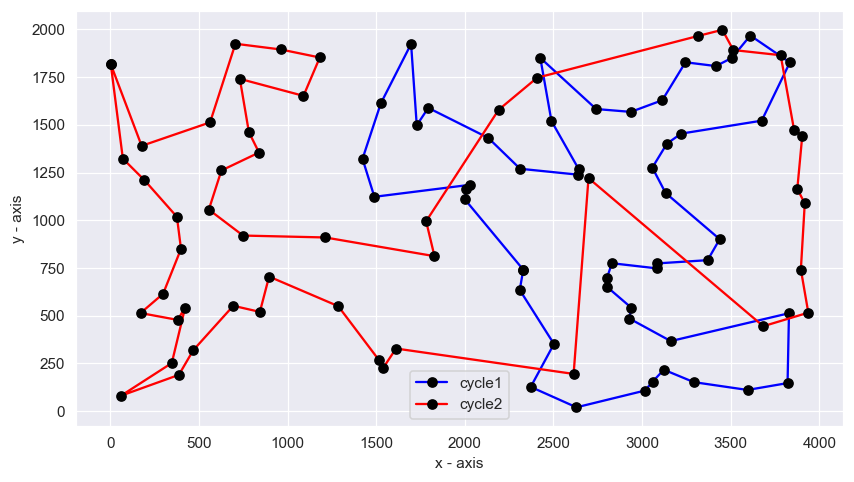

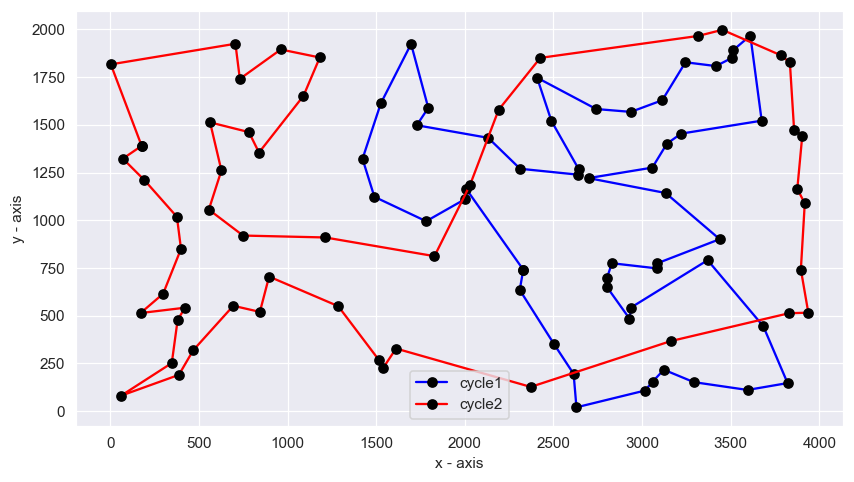

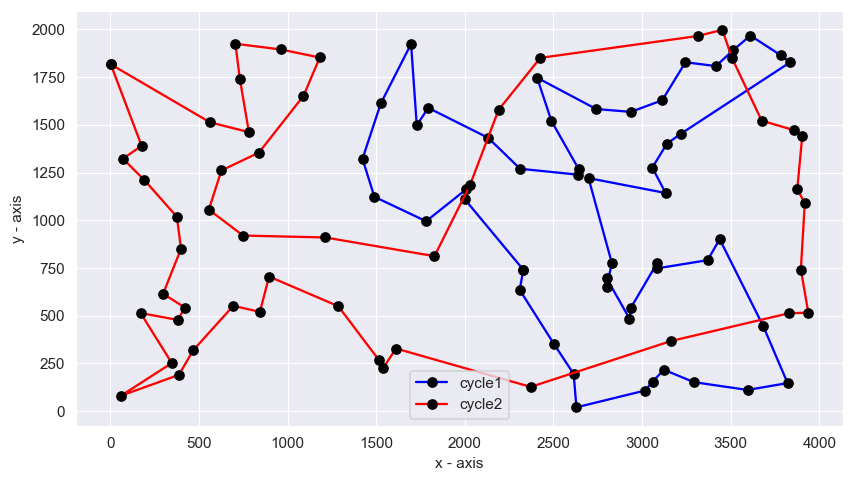

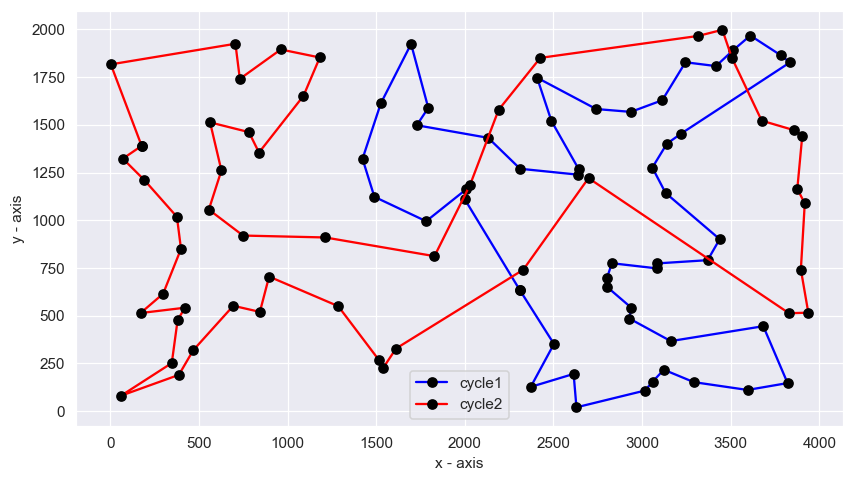

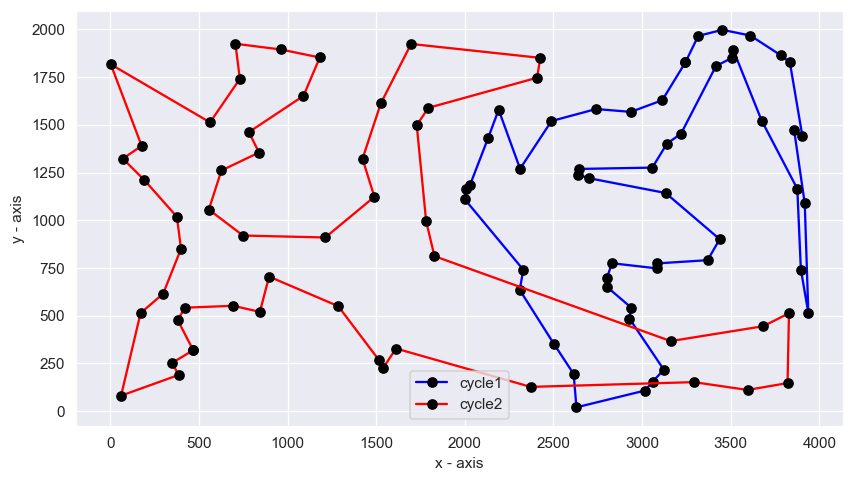

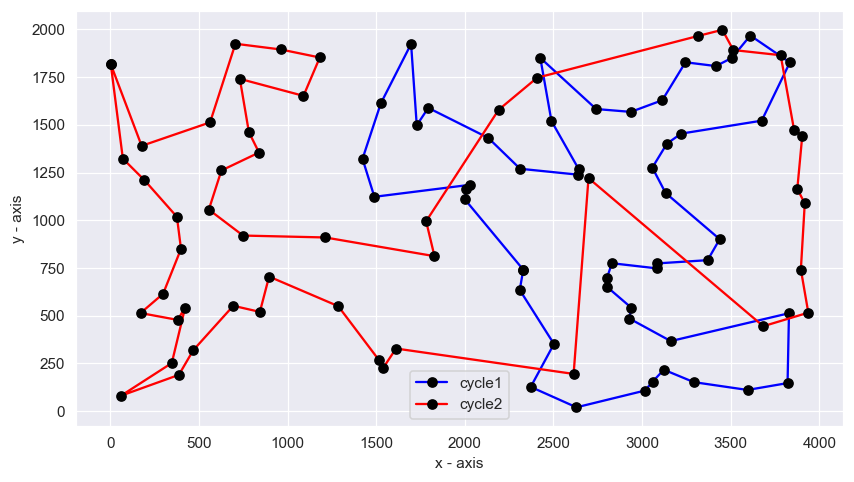

In [142]:
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')
    
for table in [results_kroB100_regret[0],results_kroB100_regret[1],results_kroB100_regret[2],
              results_kroB100_regret[3],results_kroB100_regret[4],results_kroB100_regret[5]]:    
    best_result = np.argmin(table, axis=0)
    cycle1 = table[best_result[0]][1]
    cycle2 = table[best_result[0]][2]

    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    coordinate_x_cycle1 = []
    coordinate_y_cycle1 = []
    coordinate_x_cycle2 = []
    coordinate_y_cycle2 = []
    for node in cycle1:
        coordinate_x_cycle1.append(instance2.loc[node]['x'])
        coordinate_y_cycle1.append(instance2.loc[node]['y'])
    for node in cycle2:
        coordinate_x_cycle2.append(instance2.loc[node]['x'])
        coordinate_y_cycle2.append(instance2.loc[node]['y'])

    # plotting the line 1 points
    plt.plot(coordinate_x_cycle1, coordinate_y_cycle1, '-bo',  c='blue', mfc='k', mec='k', label="cycle1")
    plt.plot(coordinate_x_cycle2, coordinate_y_cycle2, '-bo',  c='red', mfc='k', mec='k', label="cycle2")
    # naming the x axis
    plt.xlabel('x - axis')
    # naming the y axis
    plt.ylabel('y - axis')
    # giving a title to my graph

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

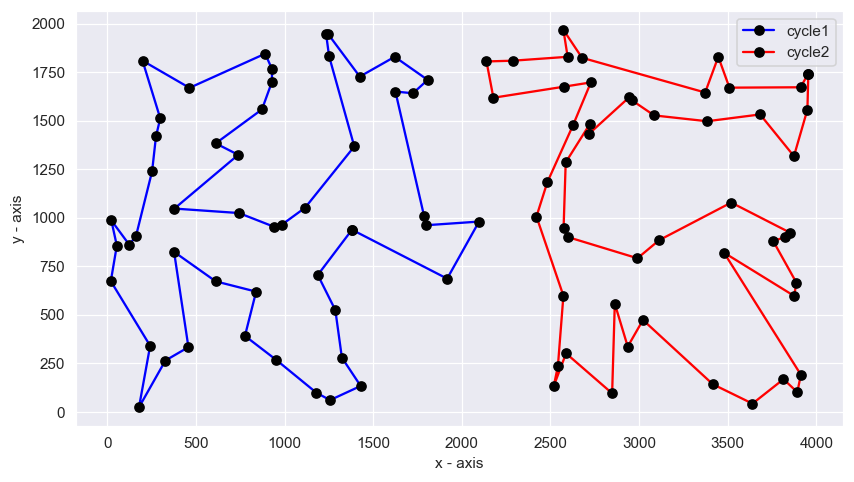

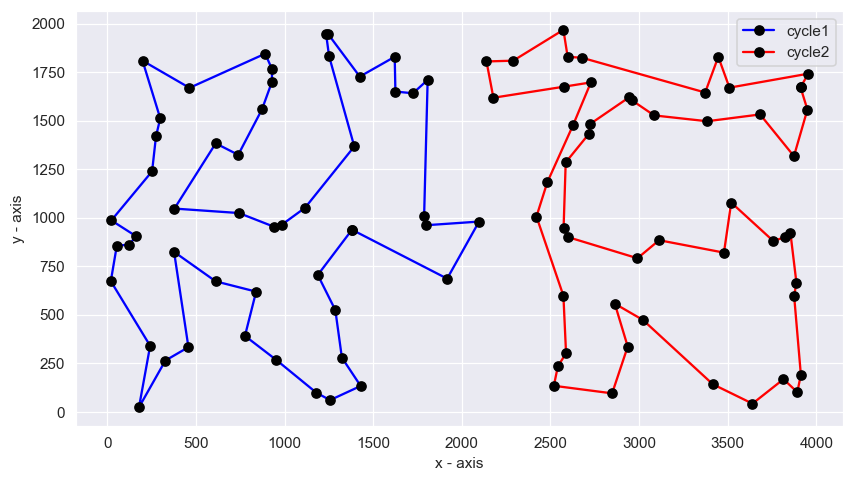

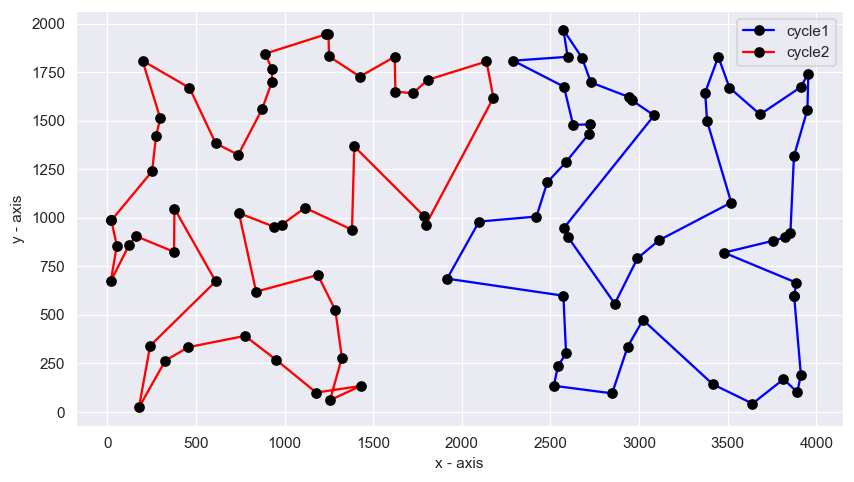

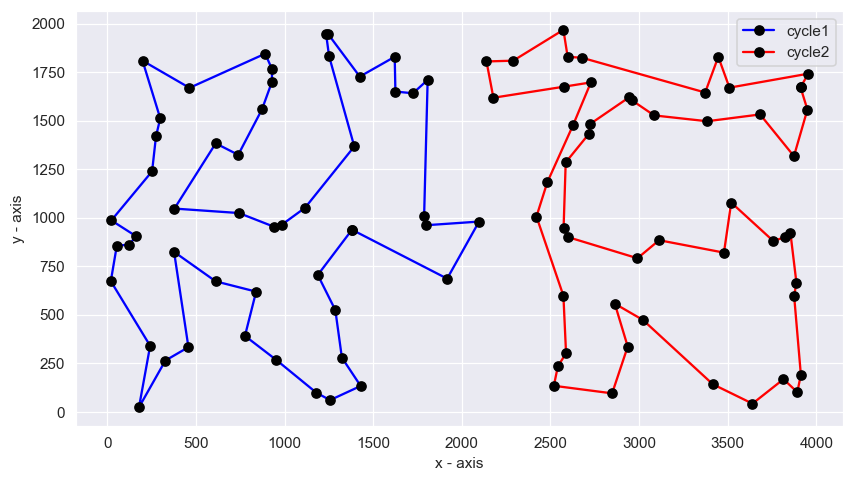

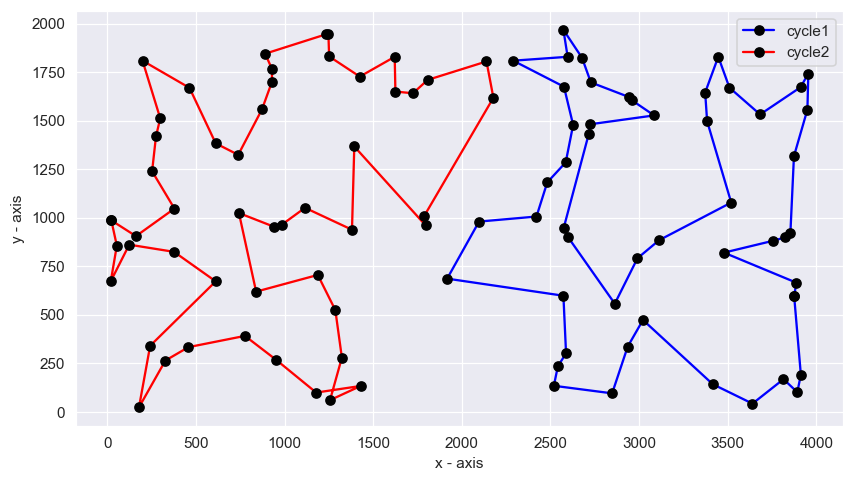

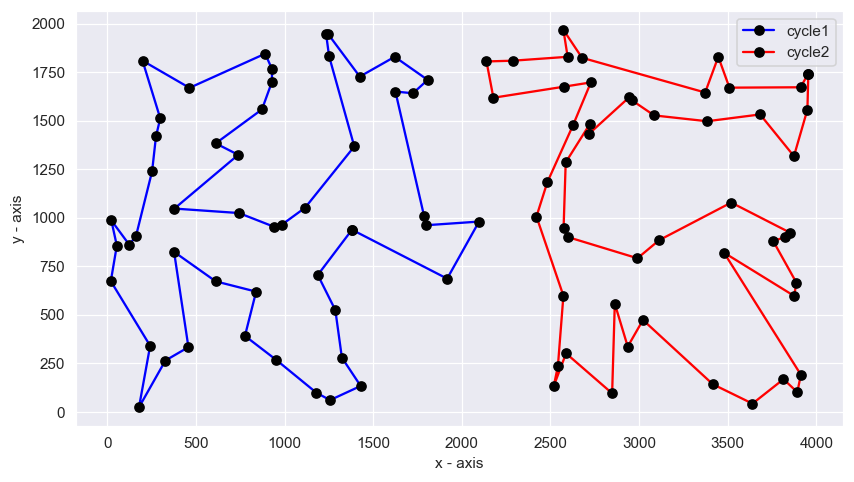

In [143]:
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')
    
for table in [results_kroA100_regret[0],results_kroA100_regret[1],results_kroA100_regret[2],
              results_kroA100_regret[3],results_kroA100_regret[4],results_kroA100_regret[5]]:    
    best_result = np.argmin(table, axis=0)
    cycle1 = table[best_result[0]][1]
    cycle2 = table[best_result[0]][2]

    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    coordinate_x_cycle1 = []
    coordinate_y_cycle1 = []
    coordinate_x_cycle2 = []
    coordinate_y_cycle2 = []
    for node in cycle1:
        coordinate_x_cycle1.append(instance.loc[node]['x'])
        coordinate_y_cycle1.append(instance.loc[node]['y'])
    for node in cycle2:
        coordinate_x_cycle2.append(instance.loc[node]['x'])
        coordinate_y_cycle2.append(instance.loc[node]['y'])

    # plotting the line 1 points
    plt.plot(coordinate_x_cycle1, coordinate_y_cycle1, '-bo',  c='blue', mfc='k', mec='k', label="cycle1")
    plt.plot(coordinate_x_cycle2, coordinate_y_cycle2, '-bo',  c='red', mfc='k', mec='k', label="cycle2")
    # naming the x axis
    plt.xlabel('x - axis')
    # naming the y axis
    plt.ylabel('y - axis')
    # giving a title to my graph

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

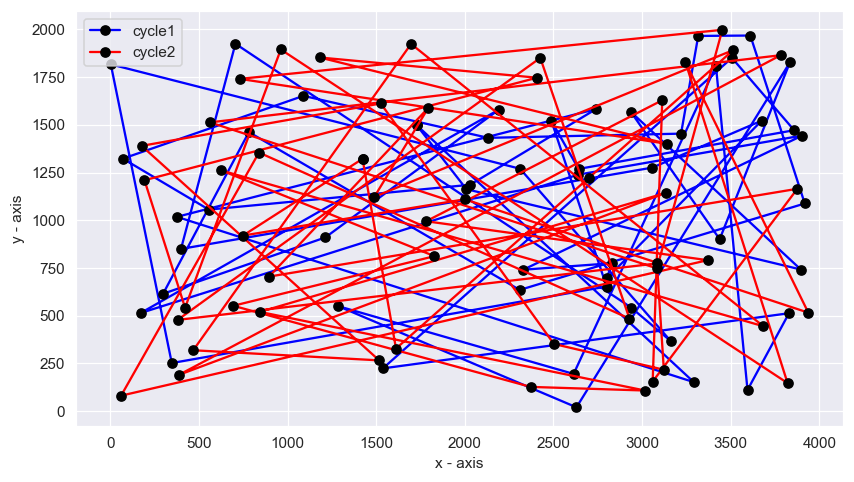

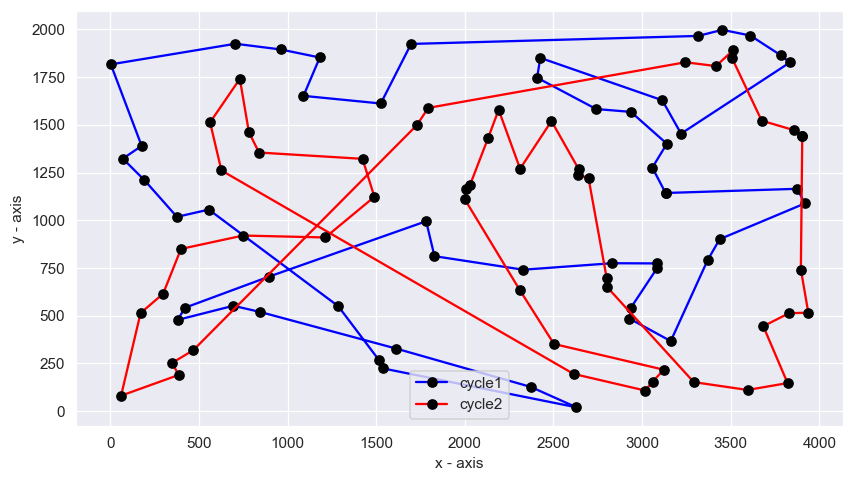

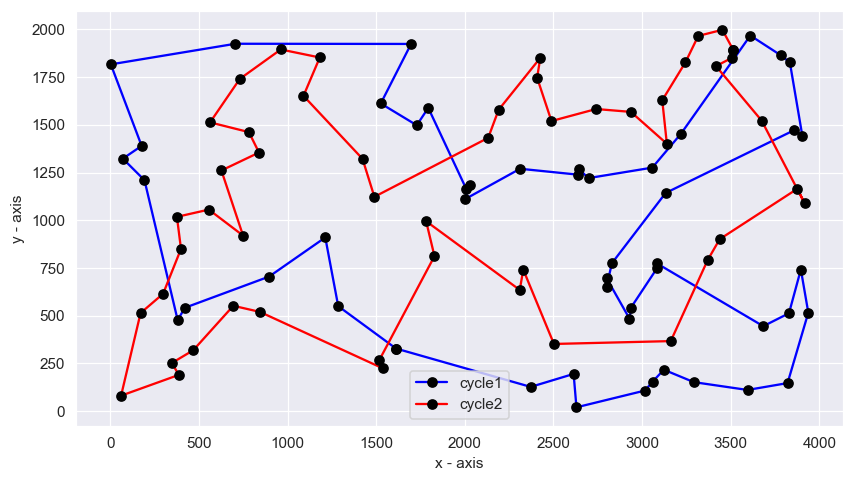

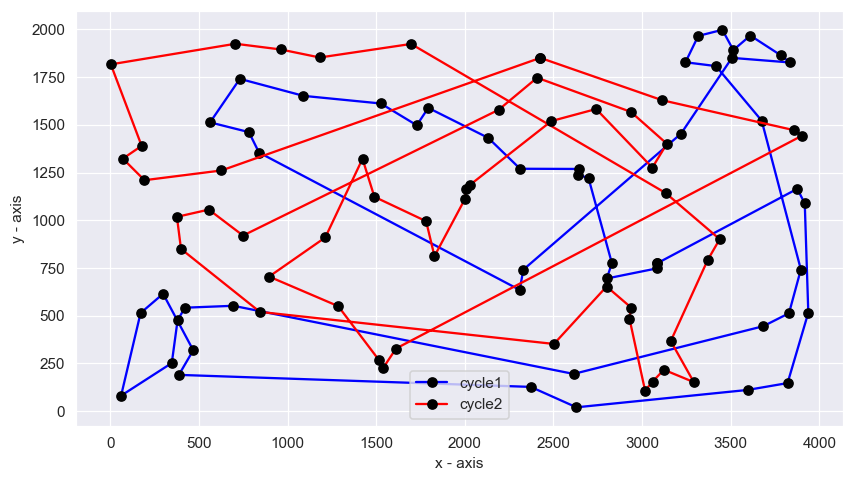

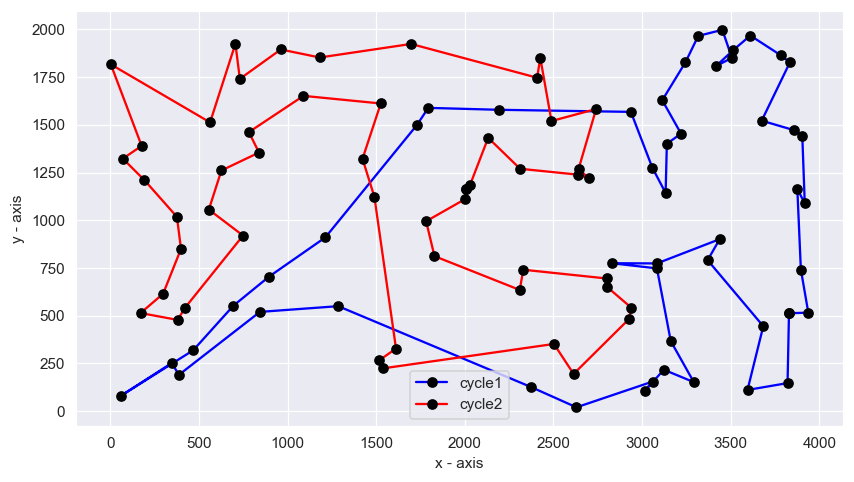

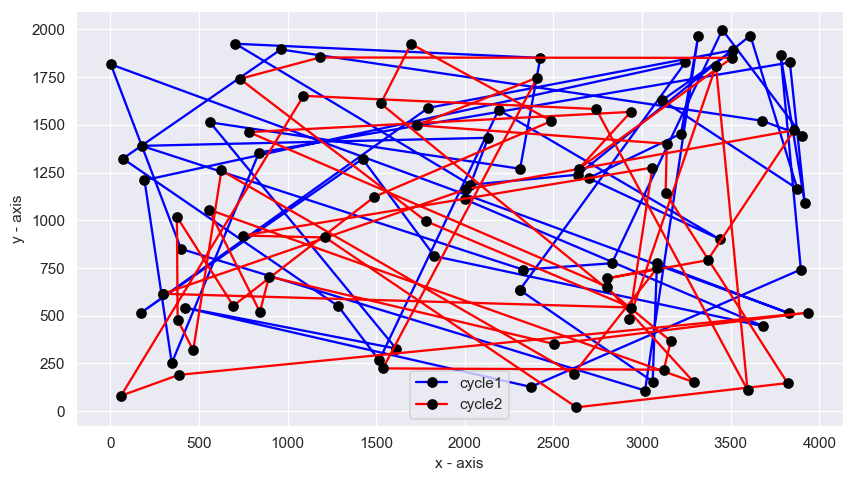

In [144]:
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')
    
for table in [results_kroB100_random[0],results_kroB100_random[1],results_kroB100_random[2],
              results_kroB100_random[3],results_kroB100_random[4],results_kroB100_random[5]]:    
    best_result = np.argmin(table, axis=0)
    cycle1 = table[best_result[0]][1]
    cycle2 = table[best_result[0]][2]

    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    coordinate_x_cycle1 = []
    coordinate_y_cycle1 = []
    coordinate_x_cycle2 = []
    coordinate_y_cycle2 = []
    for node in cycle1:
        coordinate_x_cycle1.append(instance2.loc[node]['x'])
        coordinate_y_cycle1.append(instance2.loc[node]['y'])
    for node in cycle2:
        coordinate_x_cycle2.append(instance2.loc[node]['x'])
        coordinate_y_cycle2.append(instance2.loc[node]['y'])

    # plotting the line 1 points
    plt.plot(coordinate_x_cycle1, coordinate_y_cycle1, '-bo',  c='blue', mfc='k', mec='k', label="cycle1")
    plt.plot(coordinate_x_cycle2, coordinate_y_cycle2, '-bo',  c='red', mfc='k', mec='k', label="cycle2")
    # naming the x axis
    plt.xlabel('x - axis')
    # naming the y axis
    plt.ylabel('y - axis')
    # giving a title to my graph

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

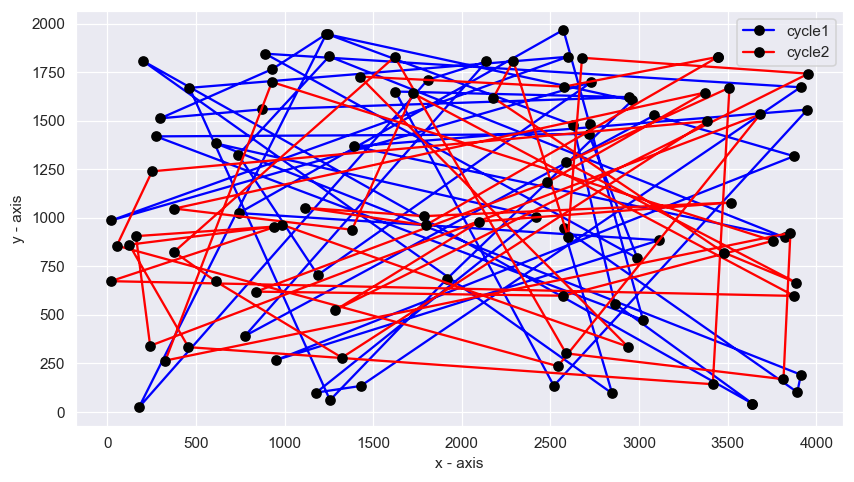

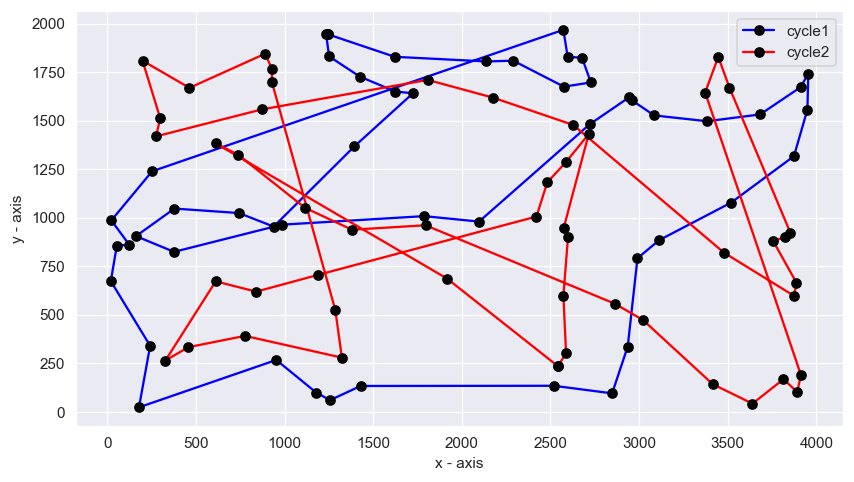

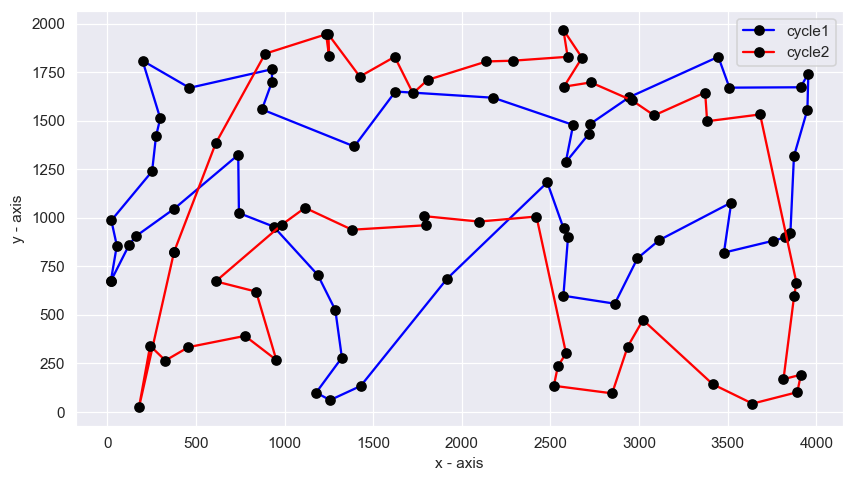

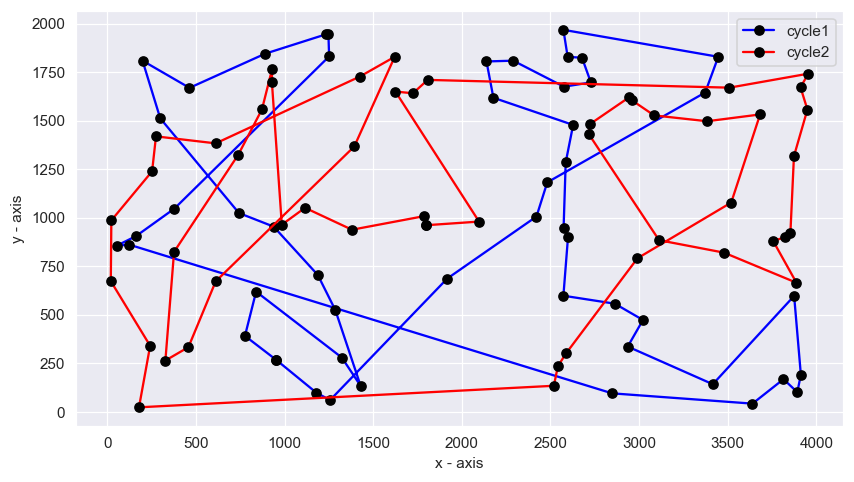

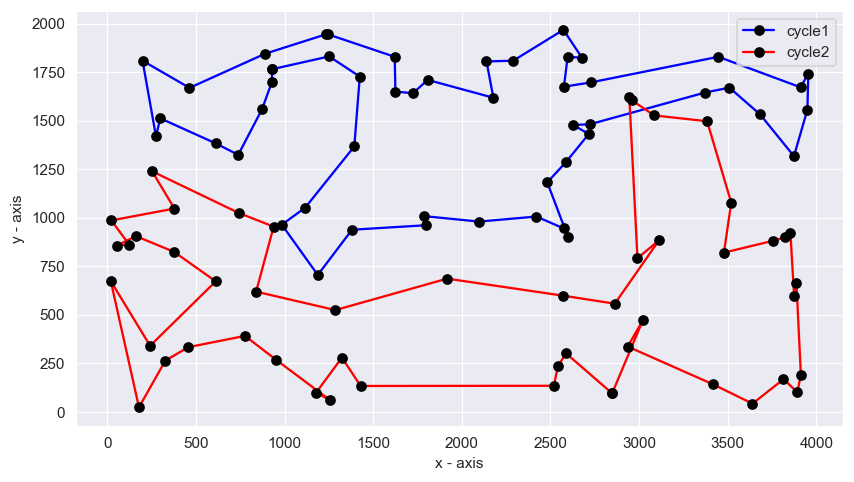

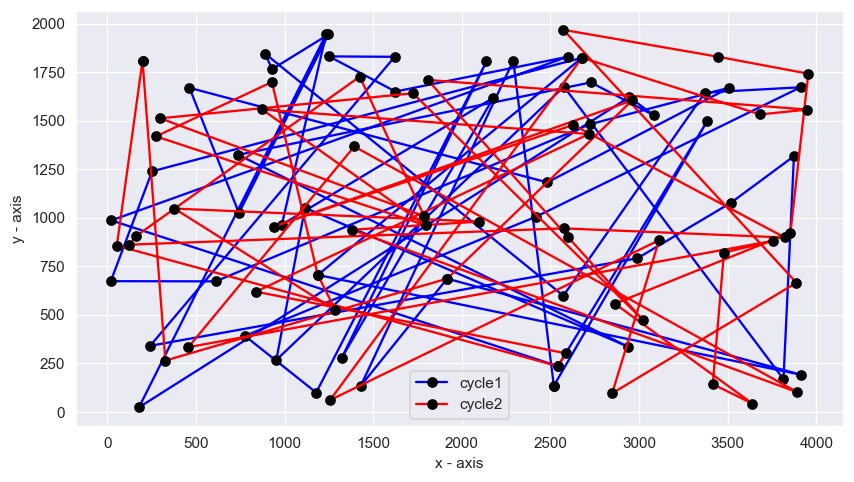

In [145]:
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')
    
for table in [results_kroA100_random[0],results_kroA100_random[1],results_kroA100_random[2],
              results_kroA100_random[3],results_kroA100_random[4],results_kroA100_random[5]]:    
    best_result = np.argmin(table, axis=0)
    cycle1 = table[best_result[0]][1]
    cycle2 = table[best_result[0]][2]

    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    coordinate_x_cycle1 = []
    coordinate_y_cycle1 = []
    coordinate_x_cycle2 = []
    coordinate_y_cycle2 = []
    for node in cycle1:
        coordinate_x_cycle1.append(instance.loc[node]['x'])
        coordinate_y_cycle1.append(instance.loc[node]['y'])
    for node in cycle2:
        coordinate_x_cycle2.append(instance.loc[node]['x'])
        coordinate_y_cycle2.append(instance.loc[node]['y'])

    # plotting the line 1 points
    plt.plot(coordinate_x_cycle1, coordinate_y_cycle1, '-bo',  c='blue', mfc='k', mec='k', label="cycle1")
    plt.plot(coordinate_x_cycle2, coordinate_y_cycle2, '-bo',  c='red', mfc='k', mec='k', label="cycle2")
    # naming the x axis
    plt.xlabel('x - axis')
    # naming the y axis
    plt.ylabel('y - axis')
    # giving a title to my graph

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()